Dataset has been successfully loaded

Handle Missing Values

Missing values after median imputation: 
 ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

Data Imbalance Check
Potability
0    1998
1    1278
Name: count, dtype: int64
Potability
0    60.989011
1    39.010989
Name: proportion, dtype: float64
SMOTE Application to handle dataset imbalance

Before SMOTE: [1586 1034]

After SMOTE: [1586 1586]

Starting Hyperparameter Tuning for SVM

Best Tuning Parameters (SVM): {'kernel': 'rbf', 'gamma': 0.1, 'class_weight': None, 'C': 10}
Best Tuned SVM F1 Score (on CV data): 0.6882

====================== Random Forest ======================
Accuracy: 0.6326
ROC AUC Score: 0.6666
Classification Report:


,precision,recall,f1-score,support
0,0.699301,0.728155,0.713436,412.000000
1,0.506608,0.471311,0.488323,244.000000
accuracy,0.632622,0.632622,0.632622,0.632622
macro avg,0.602954,0.599733,0.600880,656.000000
weighted avg,0.627628,0.632622,0.629705,656.000000



====================== Logistic Regression ======================
Accuracy: 0.6616
ROC AUC Score: 0.6477
Classification Report:


,precision,recall,f1-score,support
0,0.707424,0.786408,0.744828,412.000000
1,0.555556,0.450820,0.497738,244.000000
accuracy,0.661585,0.661585,0.661585,0.661585
macro avg,0.631490,0.618614,0.621283,656.000000
weighted avg,0.650936,0.661585,0.652922,656.000000



====================== KNN ======================
Accuracy: 0.5991
ROC AUC Score: 0.6238
Classification Report:


,precision,recall,f1-score,support
0,0.714697,0.601942,0.653491,412.000000
1,0.469256,0.594262,0.524412,244.000000
accuracy,0.599085,0.599085,0.599085,0.599085
macro avg,0.591977,0.598102,0.588952,656.000000
weighted avg,0.623405,0.599085,0.605480,656.000000



====================== SVM ======================
Accuracy: 0.6280
ROC AUC Score: 0.6704
Classification Report:


,precision,recall,f1-score,support
0,0.729508,0.648058,0.686375,412.000000
1,0.500000,0.594262,0.543071,244.000000
accuracy,0.628049,0.628049,0.628049,0.628049
macro avg,0.614754,0.621160,0.614723,656.000000
weighted avg,0.644142,0.628049,0.633073,656.000000


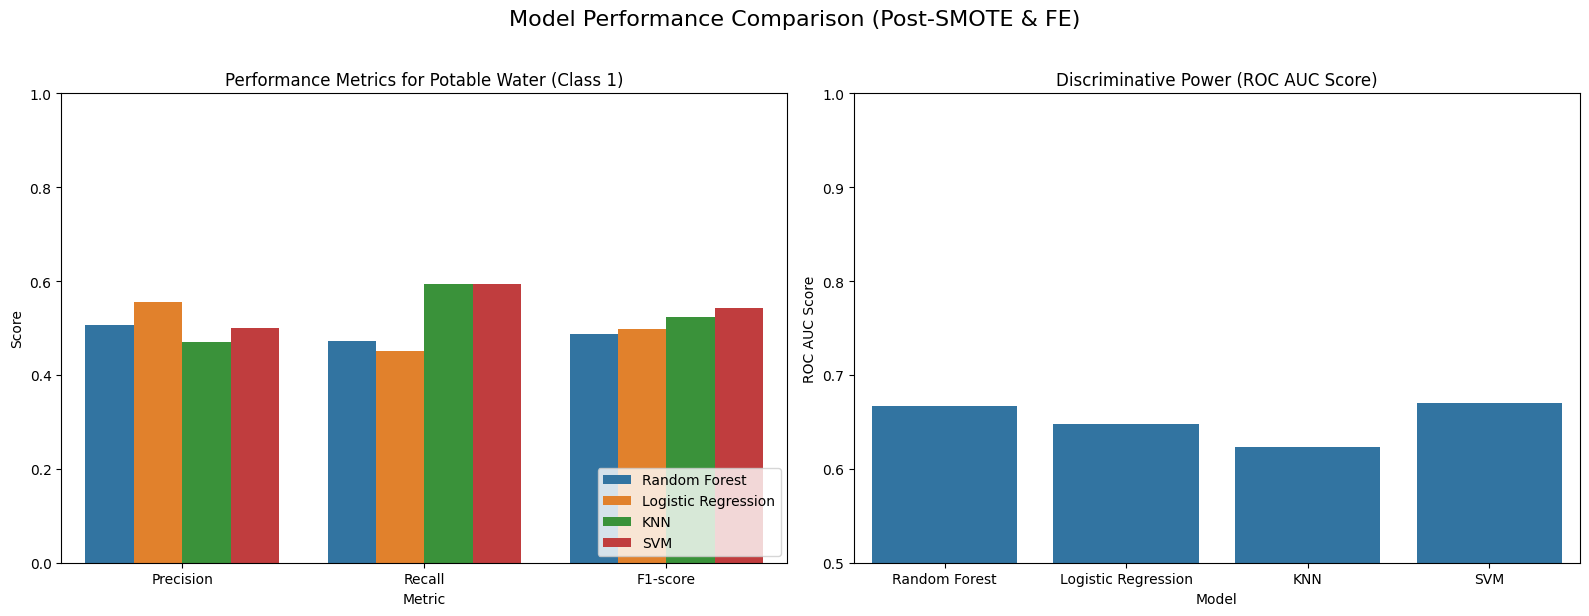

Confusion Matrix


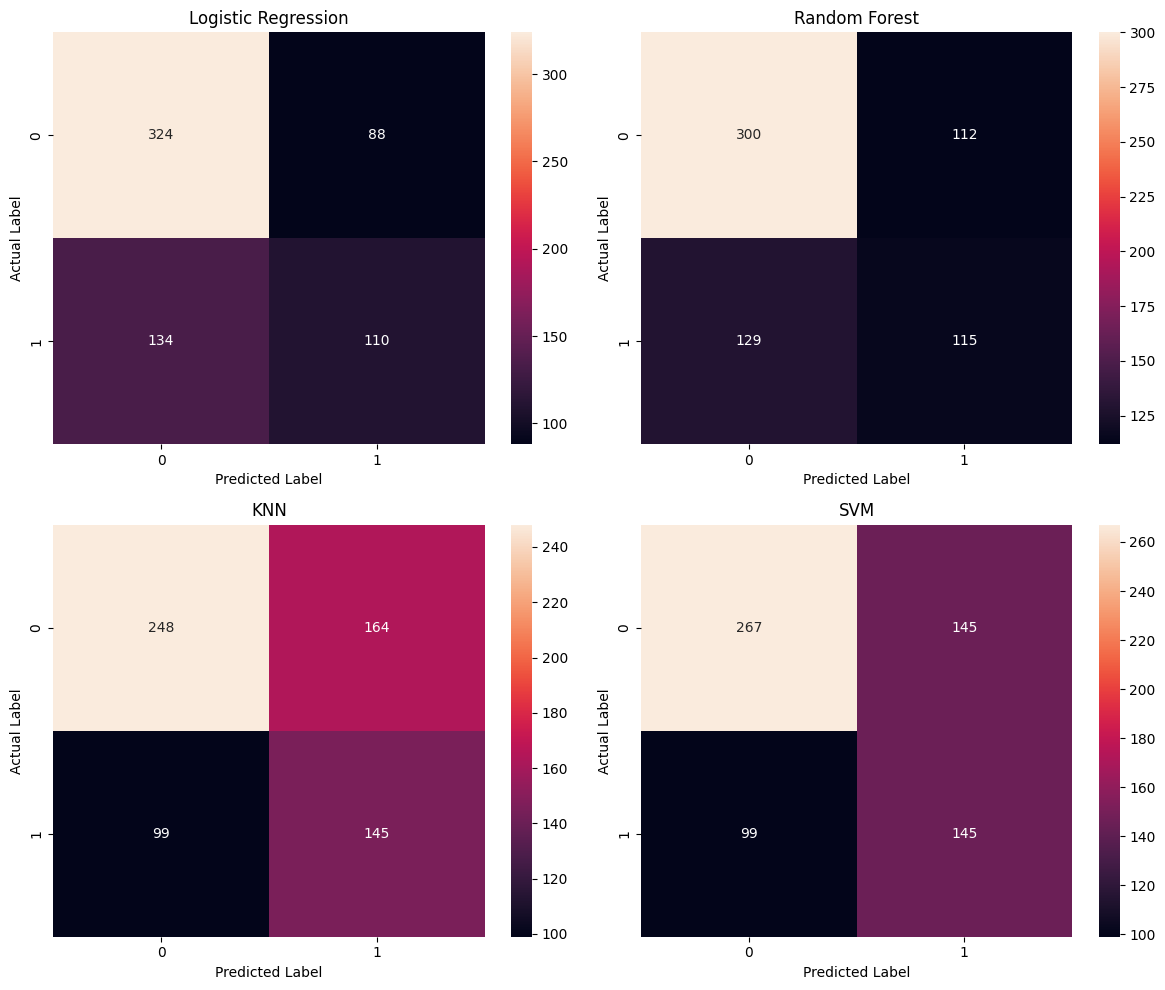


Logistics Regression Accuracy Score: 0.6615853658536586
Random Forest Accuracy Score: 0.6326219512195121
K-Nearest Neighbor Accuracy Score: 0.5990853658536586
Support Vector Machine Accuracy Score: 0.6280487804878049


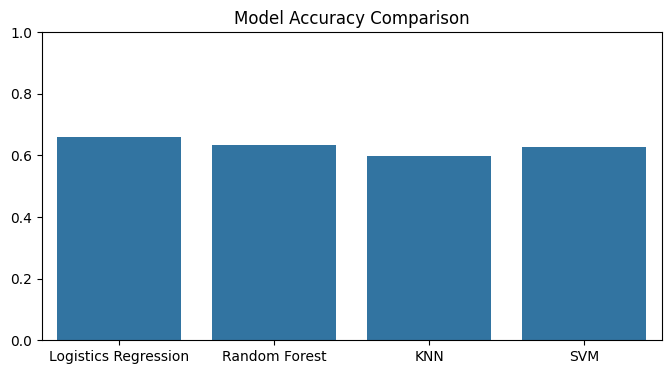

Tuned SVM Model and Scaler saved successfully to the backend folder.


In [19]:
#Data & Math
import numpy as np
import pandas as pd

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import accuracy_score,  classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE #SMOTE to solve imbalanced dataset

# Save model
import joblib

# Loading the dataset
df = pd.read_csv('C:/WaterQualityClassification/backend/dataset/water_potability.csv')
print("Dataset has been successfully loaded")
df.head

# Cleaning the data
# Handling missing values
print("\nHandle Missing Values")
df = df.fillna(df.median())
print("\nMissing values after median imputation: \n", df.isna().sum())

# Feature Engineering
df['Total_Contaminants'] = df['Chloramines'] + df['Sulfate'] + df['Trihalomethanes']
df['pH_Ratio'] = df['ph'] / df['Sulfate']
df['Stability_Index'] = df['Solids'] / df['Conductivity']

# Data Exploration
# print("\nData Exploration")
# df.info()
# print(df.isna().sum())

# Check if dataset is imbalanced
print("\nData Imbalance Check")
print(df["Potability"].value_counts())
print(df["Potability"].value_counts(normalize=True) * 100)

# Features and Label
X = df.drop('Potability', axis=1)
y = df['Potability']

#Train/Test Split
X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Applying SMOTE on training data
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("SMOTE Application to handle dataset imbalance")
print("\nBefore SMOTE:", np.bincount(y_train))
print("\nAfter SMOTE:", np.bincount(y_train_sm))

#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# ==================================================================================
#                                     Model Training (Baseline Benchmarking)
# ==================================================================================

#Random Forest Training 
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_sm, y_train_sm)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

#Logistic Regression Training 
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train_sm)
lr_pred = lr.predict(X_test_scaled)
lr_proba = lr.predict_proba(X_test_scaled)[:, 1]

#KNN Training  
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_sm)
knn_pred = knn.predict(X_test_scaled)
knn_proba = knn.predict_proba(X_test_scaled)[:, 1]

# HYPERPARAMETER TUNING for SVM (Best Model)
print("\nStarting Hyperparameter Tuning for SVM")

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001, 'scale'],
    'kernel': ['rbf'],
    'class_weight': ['balanced', None]
}

rs_svm = RandomizedSearchCV(
    estimator=SVC(random_state=42, probability=True),
    param_distributions=param_grid_svm,
    n_iter=15,
    cv=5,
    scoring='f1', # Optimizing for the best metric for imbalanced data
    random_state=42,
    n_jobs=-1,
    verbose=0  
)

# SVM Training on the SMOTEd and Scaled data

rs_svm.fit(X_train_scaled, y_train_sm)

# Selecting the best estimator found during the search
svm_optimized = rs_svm.best_estimator_
svm_pred = svm_optimized.predict(X_test_scaled)
svm_proba = svm_optimized.predict_proba(X_test_scaled)[:, 1]

print(f"\nBest Tuning Parameters (SVM): {rs_svm.best_params_}")
print(f"Best Tuned SVM F1 Score (on CV data): {rs_svm.best_score_:.4f}")

#SVM Training
svm_model = SVC(kernel="rbf", probability=True)
svm_model.fit(X_train_scaled, y_train_sm)
svm_pred = svm_model.predict(X_test_scaled)
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# ==================================================================================
#                                     Model Evaluation
# ==================================================================================

def evaluate(model_name, y_true, y_pred, y_proba):
    # 1. Calculate overall metrics for high-level printing
    acc = accuracy_score(y_true, y_pred)

    try:
        roc_auc = roc_auc_score(y_true, y_proba)
    except ValueError:
        roc_auc = 0.0
        
    # Calculate high-level accuracy
    print(f"\n====================== {model_name} ======================")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Generate detailed report as a dictionary
    # The key change: output_dict=True
    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Converting the dictionary into a Pandas DataFrame for clean display
    report_df = pd.DataFrame(report_dict).transpose()
    
    print("Classification Report:")
    display(report_df) 
    
    # Return the DataFrame for subsequent comparison/storage
    return report_df 

# Evaluating the models and storing the reports (benchmarking) 
reports = {}
reports["Random Forest"] = evaluate("Random Forest", y_test, rf_pred, rf_proba)
reports["Logistic Regression"] = evaluate("Logistic Regression", y_test, lr_pred, lr_proba)
reports["KNN"] = evaluate("KNN", y_test, knn_pred, knn_proba)
reports["SVM"] = evaluate("SVM", y_test, svm_pred, svm_proba)

# 1. Gather data for the bar chart
metric_data = []
roc_auc_scores = {}

for name, df_report in reports.items():
    # Extract metrics for the critical minority class (1: Potable)
    minority_class_metrics = df_report.loc['1', ['precision', 'recall', 'f1-score']]
    
    # Extract ROC AUC from the separate print output (or recalculate here for certainty)
    # Using the stored y_proba for accuracy
    if name == "Random Forest": y_proba = rf_proba
    elif name == "Logistic Regression": y_proba = lr_proba
    elif name == "KNN": y_proba = knn_proba
    elif name == "SVM": y_proba = svm_proba
    
    roc_auc_scores[name] = roc_auc_score(y_test, y_proba)

    # Reformat data for Seaborn plotting
    for metric, value in minority_class_metrics.items():
        metric_data.append({
            'Model': name,
            'Metric': metric.capitalize(),
            'Score': value
        })

df_metrics = pd.DataFrame(metric_data)

# 2. Create the Figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Model Performance Comparison (Post-SMOTE & FE)", fontsize=16, y=1.02)

# --- Subplot 1: Precision, Recall, F1-Score Comparison ---
sns.barplot(x='Metric', y='Score', hue='Model', data=df_metrics, ax=axes[0])
axes[0].set_title("Performance Metrics for Potable Water (Class 1)")
axes[0].set_ylim(0, 1.0)
axes[0].set_ylabel("Score")
axes[0].legend(loc='lower right')

# --- Subplot 2: ROC AUC Comparison ---
df_auc = pd.DataFrame(list(roc_auc_scores.items()), columns=['Model', 'ROC AUC Score'])
sns.barplot(x='Model', y='ROC AUC Score', data=df_auc, ax=axes[1])
axes[1].set_title("Discriminative Power (ROC AUC Score)")
axes[1].set_ylim(0.5, 1.0) # AUC should be above 0.5 (random guessing)
axes[1].set_ylabel("ROC AUC Score")



plt.tight_layout()
plt.show()

#Evaluating the models
# evaluate("Logistic Regression", y_test, lr_pred)
# evaluate("Random Forest", y_test, rf_pred)
# evaluate("KNN", y_test, knn_pred)
# evaluate("SVM", y_test, svm_pred)

#Confusion Matrices
models = {
    "Logistic Regression": lr_pred,
    "Random Forest": rf_pred,
    "KNN": knn_pred,
    "SVM": svm_pred
}
print("Confusion Matrix")
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt="d", ax=ax[0,0])
ax[0,0].set_title("Logistic Regression")
ax[0,0].set_xlabel("Predicted Label")
ax[0,0].set_ylabel("Actual Label")

sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt="d", ax=ax[0,1])
ax[0,1].set_title("Random Forest")
ax[0,1].set_xlabel("Predicted Label")
ax[0,1].set_ylabel("Actual Label")

sns.heatmap(confusion_matrix(y_test, knn_pred), annot=True, fmt="d", ax=ax[1,0])
ax[1,0].set_title("KNN")
ax[1,0].set_xlabel("Predicted Label")
ax[1,0].set_ylabel("Actual Label")

sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt="d", ax=ax[1,1])
ax[1,1].set_title("SVM")
ax[1,1].set_xlabel("Predicted Label")
ax[1,1].set_ylabel("Actual Label")


plt.tight_layout()
plt.show()

# #Debugging precision for logistics regression
# print("Unique predictions in Logistic Regression:", np.unique(lr_pred))
# print("Unique predictions in Random Forest:", np.unique(rf_pred))
# print("Unique predictions in KNN:", np.unique(knn_pred))
# print("Unique predictions in SVM:", np.unique(svm_pred))

##############################################################################


#Comparing Accuracies
models = ["Logistics Regression", "Random Forest", "KNN", "SVM"]
accuracies = [
    accuracy_score(y_test, lr_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, knn_pred),
    accuracy_score(y_test, svm_pred)
]

print(f"\nLogistics Regression Accuracy Score: {accuracies[0]}")
print(f"Random Forest Accuracy Score: {accuracies[1]}")
print(f"K-Nearest Neighbor Accuracy Score: {accuracies[2]}")
print(f"Support Vector Machine Accuracy Score: {accuracies[3]}")
plt.figure(figsize=(8,4))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()


#Saving the best model
joblib.dump(svm_optimized, "../backend/water_quality_model.pkl")
joblib.dump(scaler, "../backend/scaler.pkl")
print("Tuned SVM Model and Scaler saved successfully to the backend folder.")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
